In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data and remove outliers

In [14]:
# Load the data
df1 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_05_07.csv")
df2 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_20_06.csv")
df3 = pd.read_csv(r"C:\Users\User\Desktop\expedia_clean_dfs\expedia_clean_df_25_06.csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

In [8]:
# Remove outliers in 'price_per_night' using the IQR method
Q1 = df['price_per_night'].quantile(0.25)
Q3 = df['price_per_night'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out rows where 'price_per_night' is an outlier
df = df[(df['price_per_night'] >= lower_bound) & (df['price_per_night'] <= upper_bound)]

In [ ]:
df["full_price"] = df["price_per_night"] * df["LOS"]

# Run neural network model to predict price per night: 

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
36 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", 

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.6426759808701504, 'Train RMSE': 36.37822875080758, 'Train MSE': 1323.375527046083, 'Train MAE': 24.04465103449755, 'Test R2': 0.6283636695496537, 'Test RMSE': 37.05159740223342, 'Test MSE': 1372.8208700571904, 'Test MAE': 24.459801931687693, 'Train Size': 58410, 'Test Size': 25033, 'Best Parameters': {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


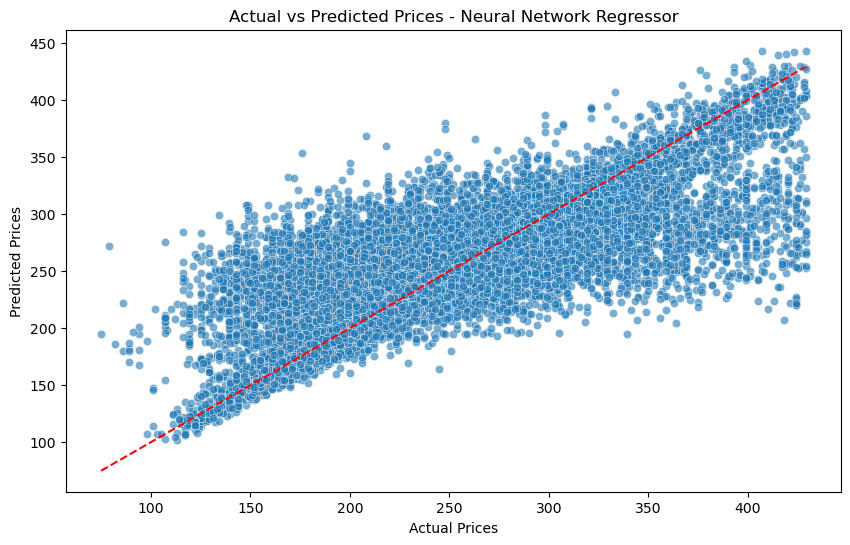

In [10]:
# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
     # Remove columns that are not needed for regression
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'price_per_night',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price_per_night'])
    y = df['price_per_night']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Feature engineering process on the data: 

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# df = pd.concat([df1, df2, df3], ignore_index=True)

# Ensure 'Snapshot' is in datetime format
df['Snapshot'] = pd.to_datetime(df['Snapshot'], errors='coerce')

# Ensure 'TTT' and 'LOS' are numeric
df['TTT'] = pd.to_numeric(df['TTT'], errors='coerce')
df['LOS'] = pd.to_numeric(df['LOS'], errors='coerce')

# Calculate check-in date by adding 'TTT' to 'Snapshot'
df['checkin'] = df['Snapshot'] + pd.to_timedelta(df['TTT'], unit='d')

# Calculate check-out date by adding 'LOS' to 'checkin'
df['checkout'] = df['checkin'] + pd.to_timedelta(df['LOS'], unit='d')

# Add columns for the day name of check-in and check-out
df['checkin_day_name'] = df['checkin'].dt.day_name()
df['checkout_day_name'] = df['checkout'].dt.day_name()

# Convert day names to categorical variables
df['checkin_day_name'] = df['checkin_day_name'].astype('category')
df['checkout_day_name'] = df['checkout_day_name'].astype('category')


# Calculate check-in date by adding 'TTT' to 'Snapshot'
df['checkin'] = df['Snapshot'] + pd.to_timedelta(df['TTT'], unit='d')

# Calculate check-out date by adding 'LOS' to 'checkin'
df['checkout'] = df['checkin'] + pd.to_timedelta(df['LOS'], unit='d')

# Add columns for the day of the month for check-in and check-out
df['checkin_day'] = df['checkin'].dt.day
df['checkout_day'] = df['checkout'].dt.day

# Function to determine the period of the month
def determine_period(start_day, end_day):
    avg_day = (start_day + end_day) / 2
    if avg_day < 10:
        return 'beginning of the month'
    elif 10 <= avg_day < 22:
        return 'middle of the month'
    else:
        return 'end of the month'

# Apply the function to create the 'period_of_the_month' column
df['period_of_the_month'] = df.apply(lambda row: determine_period(row['checkin_day'], row['checkout_day']), axis=1)

# Perform one-hot encoding for 'checkin_day_name', 'checkout_day_name', and 'period_of_the_month'
checkin_encoder = OneHotEncoder(sparse=False)
encoded_checkin = checkin_encoder.fit_transform(df[['checkin_day_name']])

checkout_encoder = OneHotEncoder(sparse=False)
encoded_checkout = checkout_encoder.fit_transform(df[['checkout_day_name']])

period_encoder = OneHotEncoder(sparse=False)
encoded_period = period_encoder.fit_transform(df[['period_of_the_month']])

# Create DataFrames for the encoded columns
encoded_checkin_df = pd.DataFrame(encoded_checkin, columns=checkin_encoder.get_feature_names_out(['checkin_day_name']))
encoded_checkout_df = pd.DataFrame(encoded_checkout, columns=checkout_encoder.get_feature_names_out(['checkout_day_name']))
encoded_period_df = pd.DataFrame(encoded_period, columns=period_encoder.get_feature_names_out(['period_of_the_month']))

# Drop the original columns and concatenate the new one-hot encoded columns
df = df.drop(columns=['checkin_day_name', 'checkout_day_name', 'period_of_the_month'])
df = df.join(encoded_checkin_df).join(encoded_checkout_df).join(encoded_period_df)

# Save the updated DataFrame to a new CSV file
# output_file = './05_07_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv'
# df.to_csv(output_file, index=False)

# Display the first few rows of the updated DataFrame
print(df.head())

C:\Users\User\AppData\Local\Temp\ipykernel_10840\1617303282.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Snapshot'] = pd.to_datetime(df['Snapshot'], errors='coerce')


             Snapshot  start_date    end_date  \
0 2024-07-12 14:43:00  06/07/2024  07/07/2024   
1 2024-07-12 14:43:06  06/07/2024  07/07/2024   
2 2024-07-12 14:43:06  06/07/2024  07/07/2024   
4 2024-07-12 14:43:06  06/07/2024  07/07/2024   
5 2024-07-12 14:43:06  06/07/2024  07/07/2024   

                                         name  TTT  LOS  score  reviews  \
0                     Hyatt House Jersey City    1    1   8.68     1299   
1  Courtyard New York Manhattan/ Midtown East    1    1   8.88     2021   
2                        Omni Berkshire Place    1    1   9.29     1223   
4              The New Yorker A Wyndham Hotel    1    1   8.28     4647   
5                  The Washington by LuxUrban    1    1   8.28     1006   

   price_per_night  original_price  ... checkout_day_name_Monday  \
0              213             237  ...                      0.0   
1              297             607  ...                      0.0   
2              269             299  ...           

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Run neural network model on with feature engineering to predict the price per night

Fitting 3 folds for each of 96 candidates, totalling 288 fits


C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", 

Results for Neural Network Regressor:
{'Model': 'Neural Network Regressor', 'Train R2': 0.6837295248886208, 'Train RMSE': 34.224709451513085, 'Train MSE': 1171.330737040489, 'Train MAE': 22.9326452415911, 'Test R2': 0.6752978351078521, 'Test RMSE': 34.63302663835947, 'Test MSE': 1199.4465341333166, 'Test MAE': 23.245631210243662, 'Train Size': 58410, 'Test Size': 25033, 'Best Parameters': {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}}


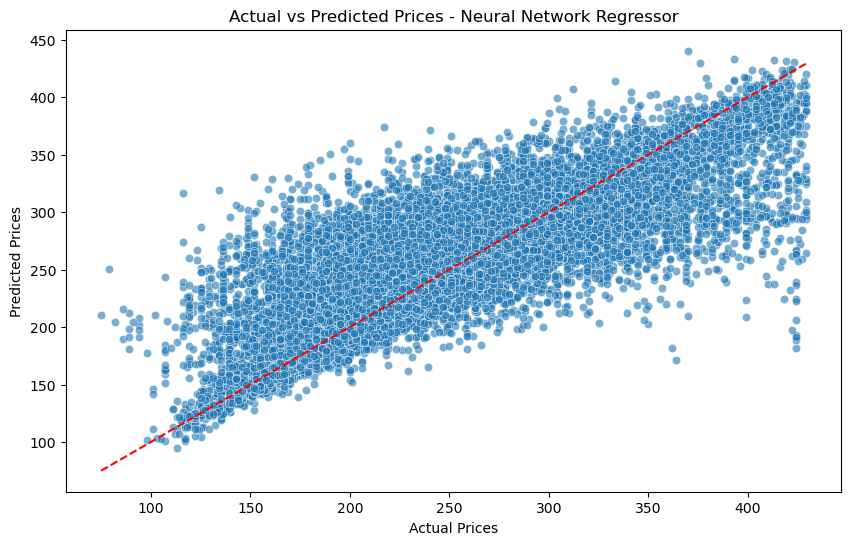

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'price_per_night',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center',
           'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
           'checkin_day_name_Monday', 'checkin_day_name_Saturday',
           'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
           'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
           'checkin_day_name_nan', 'checkout_day_name_Friday',
           'checkout_day_name_Monday', 'checkout_day_name_Saturday',
           'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
           'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
           'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
           'period_of_the_month_end of the month',
           'period_of_the_month_middle of the month']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['price_per_night'])
    y = df['price_per_night']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Run neural network model to predict the full price

In [ ]:
# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
     # Remove columns that are not needed for regression
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()

# Run neural network model after features engineering to predict the full price

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Merge the dataframes
# df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Neural Network Regression and calculate metrics
def run_neural_network_regressor(df):
    columns_to_use = ['TTT', 'LOS', 'score',
           'reviews', 'full_price',
           'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
           'star_rating', 'location_rating',
           'km_from_center',
           'checkin_day', 'checkout_day', 'checkin_day_name_Friday',
           'checkin_day_name_Monday', 'checkin_day_name_Saturday',
           'checkin_day_name_Sunday', 'checkin_day_name_Thursday',
           'checkin_day_name_Tuesday', 'checkin_day_name_Wednesday',
           'checkin_day_name_nan', 'checkout_day_name_Friday',
           'checkout_day_name_Monday', 'checkout_day_name_Saturday',
           'checkout_day_name_Sunday', 'checkout_day_name_Thursday',
           'checkout_day_name_Tuesday', 'checkout_day_name_Wednesday',
           'checkout_day_name_nan', 'period_of_the_month_beginning of the month',
           'period_of_the_month_end of the month',
           'period_of_the_month_middle of the month']
    df = df[columns_to_use]
    
    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }
    
    # Initialize Neural Network Regressor with GridSearchCV
    model = MLPRegressor(max_iter=500, random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Model': 'Neural Network Regressor',
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test),
        'Best Parameters': grid_search.best_params_
    }
    
    return results, y_test, y_test_pred

# Run Neural Network Regressor
results, y_test, y_test_pred = run_neural_network_regressor(df)

# Display results
print("Results for Neural Network Regressor:")
print(results)

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices - Neural Network Regressor')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()